### Написание и обучение классификатора на основе CNN

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms 
import skimage
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
from torchvision import transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import gc

%matplotlib inline

In [3]:
BASE_DIR = "/kaggle/input/indoor-outdoor-classification"

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
labels_map = {
    0 : "indoor",
    1 : "outdoor"
    
}

Трансформации для картинок

In [14]:

transformations = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((128, 128)),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])  
    
#     transforms.RandomHorizontalFlip(p=0.5),
   
])




С помощью ImageFolder создаем датасеты и даталоадеры

In [15]:
# dir_indoor = '/kaggle/input/indoor-outdoor-dz3-techno/indoor'
# dir_outdoor = '/kaggle/input/indoor-outdoor-dz3-techno/outdoor'
full_data = ImageFolder(BASE_DIR, transform=transformations)


In [16]:
train_size = int(0.2* len(full_data))
val_size = int(0.05 * len(full_data))
test_size = (len(full_data) - train_size - val_size)

train_data, val_data, test_data = random_split(full_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [17]:
len(train_loader)

642

Я взял модель VGG и воссоздал ее архитектуру. Однако, если обучать на данном датасете, уходит очень много времени, поэтому воспользовался более простыми решениями

In [19]:
import torch.nn as nn

In [20]:

class InOutVGGClassifier(nn.Module):
    
    def __init__(self):
        super(InOutVGGClassifier,self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.4),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.4),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.4),
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.4),
        )
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(in_features=8192, out_features=4096), 
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(in_features=4096, out_features=4096), 
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(in_features=4096, out_features = 2)
        )
        
    def forward(self, X):
        
        conv_layers_output = self.block4(self.block3(self.block2(self.block1(X))))
        X_flatten = conv_layers_output.view(conv_layers_output.shape[0], -1) 
        
        result = self.fully_connected_layers(X_flatten)
        return result


Более легковесная модель. В ней есть батч-нормализация, которая немного улучшает качество модели.  
Также были попытки подключить дропаут, но показалось, что это не дает прироста в качестве

In [22]:
class SmallInOutClassifier(nn.Module):
    def __init__(self):
        super(SmallInOutClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
#             nn.Dropout2d(p = 0.2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.Dropout2d(p = 0.2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.Dropout2d(p = 0.2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.Dropout2d(p = 0.2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(16384, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
          
            nn.Linear(512, 2),
            
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
#         print(x.size)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

Функции для обучения и валидации модели

In [23]:
def train(model, optimizer,  criterion, num_epochs, tr_dataloader, val_dataloader, scheduler = None):
    
    
    loss_score = {'train' : [], 'val' : []}
    accuracy_score = {'train' : [], 'val' : []}
    
    best_val_acc = 0
    
    for epoch in tqdm(range(num_epochs)):
        
        clear_output(wait=True)
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        
        
        
        model.train()
        
        for X_train, y_train in tr_dataloader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            optimizer.zero_grad() #обнулили градиенты 
            output = model(X_train) #сделали forward step    
            
                        
#             print(output)
            current_loss = criterion(output, y_train) #посчитали loss
            
            
            current_loss.backward() #вычислили градиент
            optimizer.step()
            
            #собираем метрики по батчу
            y_pred = output.detach().argmax(dim=1)
            
            #accuracy  
            correct +=(y_pred == y_train).type(torch.int).sum().item()
            total += y_train.size(0)
            
            #loss
            running_loss+=current_loss.item()
            
            
            
        avg_loss_train = running_loss/len(tr_dataloader)
        avg_accuracy_train = correct/total
        
        
        loss_score['train'].append(avg_loss_train)  
        accuracy_score['train'].append(avg_accuracy_train)
        
        
        
       
        
        
        
        # metrics on validatation
        loss_val, accuracy_val = evaluate_model(model, val_dataloader, criterion = criterion)
        
        loss_score['val'].append(loss_val)  
        accuracy_score['val'].append(accuracy_val)
        
        
        
        #save model with best accuracy
        if accuracy_val > best_val_acc:
            checkpoint = {
                "model_state_dict" : model.state_dict(),
                "optimizer_state_dict" : optimizer.state_dict(),
                'epoch' : epoch + 1,
                'loss_val' : loss_val,
                'accuracy_val': accuracy_val
            }
            torch.save(checkpoint, 'best_weights.pt')
            best_val_acc = accuracy_val
        
        
        if scheduler:
            #reduce learning rate
            scheduler.step()
        
        
        #logging
        
        print(f"{epoch+1} эпоха\ntrain_loss = {avg_loss_train}, val_loss = {loss_val}")
        print(f"train_accuracy = {avg_accuracy_train}, val_accuracy = {accuracy_val}")
        
        #matplotlib
        fig, axs = plt.subplots(1,2, figsize = (15,7))
        
        axs[0].plot(range(0,epoch+1),loss_score['train'], label = "train")
        axs[0].plot(range(0,epoch+1),loss_score['val'], label = "val")
        
        axs[0].grid(True)
        axs[0].legend()
        axs[0].set_title("Loss")
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss score')
        
        axs[0].set_ylim(bottom = 0, top = 1)
        
        
        axs[1].plot(range(0,epoch+1),accuracy_score['train'], label = "train")
        axs[1].plot(range(0,epoch+1),accuracy_score['val'], label = "val")
        
        axs[1].grid(True)
        axs[1].legend()
        axs[1].set_title("Accuracy")
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy score')
        
        plt.show()
        
        

        
        
    return loss_score, accuracy_score





def evaluate_model(model, val_dataloader, criterion, verbose=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
            
        
        for X_val, y_val in tqdm(val_dataloader, disable = (not verbose)):
            X_val, y_val = X_val.to(device), y_val.to(device)

            output = model(X_val)
            
            current_loss = criterion(output, y_val) #посчитали loss


            #собираем метрики по батчу
            y_pred = output.argmax(dim=1)

            right_preds = (y_pred == y_val).type(torch.int).sum().item()

            #accuracy
            correct += right_preds
            total += y_val.size(0)

            #loss 
            running_loss+=current_loss.item()
            
        
   
    loss_val = running_loss / len(val_dataloader)
    accuracy_val = correct / total

    return  loss_val, accuracy_val
        
        
        
        
    

In [36]:
torch.cuda.empty_cache() 
gc.collect()

7580

Инициализация модели. Был добавлен шедулер, который должен понижать loss через заданное количество эпох, но он не использовался, так как не улучшал качество модели

In [32]:
model = SmallInOutClassifier()
model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
criterion = nn.CrossEntropyLoss()
scheduler = None #lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.1)


20 эпоха
train_loss = 0.024471555130300186, val_loss = 0.5531122782585783
train_accuracy = 0.9917056416252558, val_accuracy = 0.9067524115755627


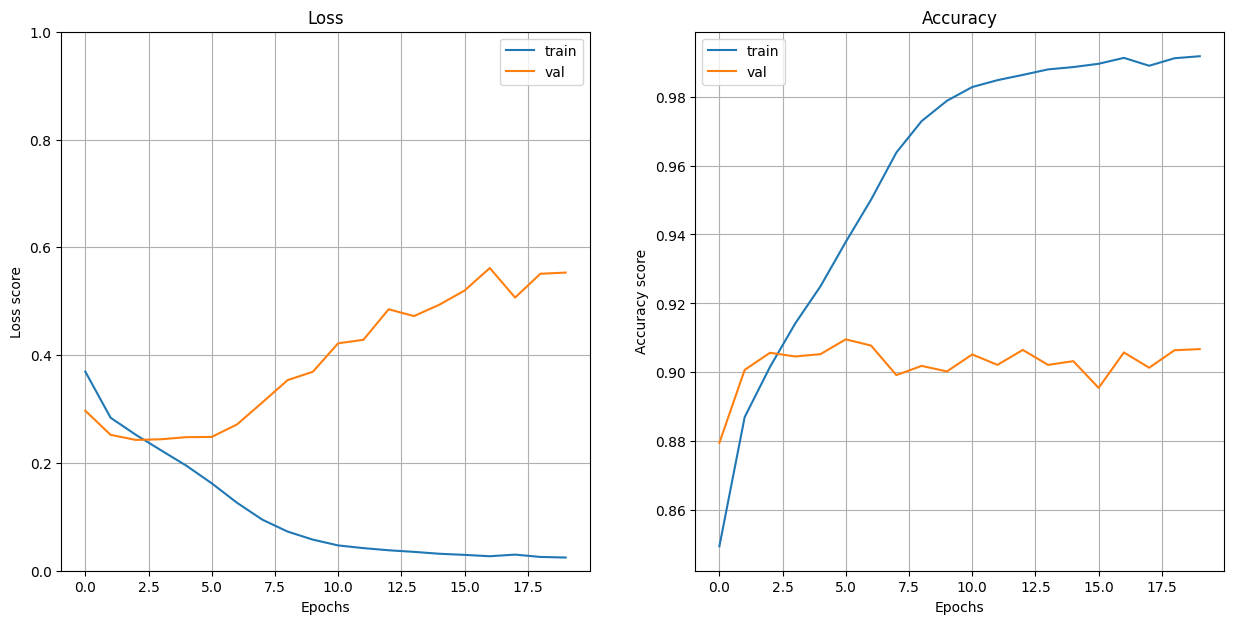

100%|██████████| 20/20 [1:49:47<00:00, 329.38s/it]


In [37]:
loss_score, accuracy_score = train(model, optimizer, criterion, num_epochs = 20, tr_dataloader = train_loader,
      val_dataloader = val_loader, scheduler=scheduler)


Модель очень быстро дала высокую точность >0.9
Видно, что модель начала переобучаться, но мы смогли сохранить веса лучшей модели

Загрузим веса модели с лучшей accuracy на валидации

In [33]:
best_weights = torch.load('/kaggle/working/best_weights.pt')

/tmp/ipykernel_30/910250004.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_weights = torch.load('/kaggle/working/best_weights.pt')


In [34]:
torch.save(best_weights, 'best_weights.pt')

Посчитаем метрики на валидации и на тесте

In [35]:
model.load_state_dict(best_weights['model_state_dict'])

<All keys matched successfully>

In [36]:
loss_val, accuracy_val = evaluate_model(model,val_loader,criterion, verbose = True)

100%|██████████| 161/161 [02:34<00:00,  1.04it/s]


In [37]:
accuracy_val

0.9198090227029134

In [38]:
loss_test, accuracy_test = evaluate_model(model,test_loader,criterion, verbose = True)

100%|██████████| 2406/2406 [38:43<00:00,  1.04it/s]


In [39]:
accuracy_test


0.9212813500750259

Таким образом, я смог обучить несложную CNN для задачи бинарной классификации. Ассuracy на test при этом составила >0.9